# TAS Analysis
___

##### Dependencies

In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mglearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.datasets import load_iris, make_classification, load_breast_cancer
from sklearn.manifold import Isomap, TSNE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD, FactorAnalysis
from sklearn.linear_model import (LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                  BayesianRidge, SGDRegressor, SGDClassifier, Perceptron,
                                  Lasso, ElasticNet, BayesianRidge, HuberRegressor)
from sklearn.svm import SVR, SVC, OneClassSVM
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, \
	PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier,
                              ExtraTreesRegressor,
                              GradientBoostingClassifier, GradientBoostingRegressor,
                              AdaBoostClassifier, AdaBoostRegressor,
                              HistGradientBoostingClassifier, HistGradientBoostingRegressor,
                              IsolationForest)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
	classification_report, r2_score, mean_squared_error, accuracy_score, precision_recall_curve,
	average_precision_score,
	precision_score, recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay,
	ConfusionMatrixDisplay
)
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from openai import OpenAI
import seaborn as sns
from booger import Error, ErrorDialog
import warnings
from importlib import reload
import datasets

In [6]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

## 🔍 Exploratory Analysis

#### Load Data


In [20]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\source\repos\Boo\data\excel\Account Balances.xlsx'
df_original = pd.read_excel( file_path_balances, sheet_name='Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
numeric_subset = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Copy original data as loaded
df_balances = df_original.copy( )

# Filter values
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'MainAccountCode', 'TreasuryAccountSymbol' ] + numeric_subset
dropcols = [ 'AccountBalancesId', 'FederalAccountSymbol', 'FederalAccountName', 'SubAccountCode',
             'LastModified', 'SubmissionPeriod', 'BudgetFunction', 'LastModified',
             'SubmissionPeriod' ]

df_balances.drop( columns=dropcols, inplace=True, errors='ignore' )
df_balances.fillna( 0, inplace=True )

# Define complete dataset
df_dataset = df_balances.copy( )

# Define working subsets
df_subset = df_dataset[ subset ].copy( )
df_numeric = df_dataset[ numeric_columns ].copy( )

print( hdr )
print( 'Original Data' )
print( nwln )

df_dataset


------------------------------------------------------------------------------------------------------------------------

Original Data




,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,TreasuryAccountSymbol,TreasuryAccountName,BudgetSubFunction,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
0,435,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,NS,NS,X,1100,435-X-1100-000,"SALARIES AND EXPENSES, OFFICE OF NAVAJO AND HO...",OTHER GENERAL GOVERNMENT,9375126.93,391778.13,0.000000e+00,0,0,0.00,5.395160e+06,391778.13,4.371745e+06,4.907144e+06,9.766905e+06
1,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,NS,NS,X,8298,306-X-8298-000,"DONATIONS, ADVISORY COUNCIL ON HISTORIC PRESER...",RECREATIONAL RESOURCES,10000.00,0.00,2.040750e+04,0,0,0.00,7.594410e+03,0.00,2.281309e+04,7.594410e+03,3.040750e+04
2,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2025,NS,2300,306-2024/2025-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",RECREATIONAL RESOURCES,0.00,0.00,0.000000e+00,0,0,3335315.06,1.023794e+06,0.00,2.311521e+06,9.386225e+05,3.335315e+06
3,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2024,2024,NS,2300,306-2024/2024-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",RECREATIONAL RESOURCES,0.00,0.00,8.585000e+06,0,0,98377.54,8.671171e+06,0.00,1.220688e+04,7.798614e+06,8.683378e+06
4,306,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2023,2024,NS,2300,306-2023/2024-2300-000,"SALARIES AND EXPENSES, ADVISORY COUNCIL ON HIS...",RECREATIONAL RESOURCES,1473398.99,643.36,0.000000e+00,0,0,-205636.56,1.268380e+06,643.36,2.559000e+01,1.265628e+06,1.268406e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,12,DEPARTMENT OF AGRICULTURE,2018,2019,NS,3539,012-2018/2019-3539-000,"CHILD NUTRITION PROGRAMS, FOOD AND NUTRITION S...",FOOD AND NUTRITION ASSISTANCE,0.00,0.00,2.422415e+10,0,0,0.00,2.206119e+10,0.00,2.162957e+09,1.820965e+10,2.422415e+10
56983,11,DEPARTMENT OF STATE,2014,2015,NS,1075,019-011-2014/2015-1075-000,"NON-PROLIFERATION, ANTI-TERRORISM, DEMINING AN...",INTERNATIONAL SECURITY ASSISTANCE,20369364.56,4999963.09,0.000000e+00,0,0,0.00,3.365290e+05,6320448.09,2.503280e+07,1.466619e+07,2.536933e+07
56984,91,DEPARTMENT OF EDUCATION,2017,2018,NS,203,091-2017/2018-0203-000,"SAFE SCHOOLS AND CITIZENSHIP EDUCATION, EDUCA...","ELEMENTARY, SECONDARY, AND VOCATIONAL EDUCATION",72769058.38,0.00,0.000000e+00,0,0,0.00,7.276894e+07,0.00,1.148900e+02,1.351539e+07,7.276906e+07
56985,75,DEPARTMENT OF HEALTH AND HUMAN SERVICES,2011,2015,NS,352,075-2011/2015-0352-000,"PRIMARY HEALTH CARE ACCESS, HEALTH RESOURCES A...",HEALTH CARE SERVICES,3611656.08,42135.04,0.000000e+00,0,0,0.00,2.956034e+04,42135.04,3.624231e+06,2.634180e+06,3.653791e+06


In [227]:
print( hdr )
print( 'Numeric' )
print( nwln )

df_numeric = df_balances[ numeric_columns ].copy( )
df_numeric


------------------------------------------------------------------------------------------------------------------------

Numeric




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
0,9375126.93000,391778.13000,0.00000,0,0,0.00000,5395160.39000,391778.13000,4371744.67000,4907144.47000,9766905.06000
1,10000.00000,0.00000,20407.50000,0,0,0.00000,7594.41000,0.00000,22813.09000,7594.41000,30407.50000
2,0.00000,0.00000,0.00000,0,0,3335315.06000,1023794.10000,0.00000,2311520.96000,938622.50000,3335315.06000
3,0.00000,0.00000,8585000.00000,0,0,98377.54000,8671170.66000,0.00000,12206.88000,7798613.88000,8683377.54000
4,1473398.99000,643.36000,0.00000,0,0,-205636.56000,1268380.20000,643.36000,25.59000,1265628.12000,1268405.79000
...,...,...,...,...,...,...,...,...,...,...,...
56982,0.00000,0.00000,24224149620.00000,0,0,0.00000,22061192524.91000,0.00000,2162957095.09000,18209646395.21000,24224149620.00000
56983,20369364.56000,4999963.09000,0.00000,0,0,0.00000,336529.00000,6320448.09000,25032798.65000,14666185.30000,25369327.65000
56984,72769058.38000,0.00000,0.00000,0,0,0.00000,72768943.49000,0.00000,114.89000,13515386.34000,72769058.38000
56985,3611656.08000,42135.04000,0.00000,0,0,0.00000,29560.34000,42135.04000,3624230.78000,2634180.31000,3653791.12000


In [225]:
print( hdr )
print( 'Subset' )
print( nwln )

df_subset


------------------------------------------------------------------------------------------------------------------------

Subset




,AgencyName,MainAccountCode,TreasuryAccountSymbol,AnnualAppropriations,CarryoverAuthority,UnobligatedBalance,Obligations,Outlays
0,OFFICE OF NAVAJO AND HOPI INDIAN RELOCATION,1100,435-X-1100-000,0.00000,9375126.93000,4371744.67000,5395160.39000,4907144.47000
1,ADVISORY COUNCIL ON HISTORIC PRESERVATION,8298,306-X-8298-000,20407.50000,10000.00000,22813.09000,7594.41000,7594.41000
2,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2300,306-2024/2025-2300-000,0.00000,0.00000,2311520.96000,1023794.10000,938622.50000
3,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2300,306-2024/2024-2300-000,8585000.00000,0.00000,12206.88000,8671170.66000,7798613.88000
4,ADVISORY COUNCIL ON HISTORIC PRESERVATION,2300,306-2023/2024-2300-000,0.00000,1473398.99000,25.59000,1268380.20000,1265628.12000
...,...,...,...,...,...,...,...,...
56982,DEPARTMENT OF AGRICULTURE,3539,012-2018/2019-3539-000,24224149620.00000,0.00000,2162957095.09000,22061192524.91000,18209646395.21000
56983,DEPARTMENT OF STATE,1075,019-011-2014/2015-1075-000,0.00000,20369364.56000,25032798.65000,336529.00000,14666185.30000
56984,DEPARTMENT OF EDUCATION,203,091-2017/2018-0203-000,0.00000,72769058.38000,114.89000,72768943.49000,13515386.34000
56985,DEPARTMENT OF HEALTH AND HUMAN SERVICES,352,075-2011/2015-0352-000,0.00000,3611656.08000,3624230.78000,29560.34000,2634180.31000


## 📊 Descriptive Statistics

In [9]:
print( hdr )
print( 'Descriptive Statistics - Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_dataset[ numeric_columns ].describe( percentiles=[ .10, .25, .5, .75, .95 ] )
df_descriptive.round( 2 )



------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Dataset




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658304e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118463e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
10%,0.000000e+00,-3.410682e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
95%,2.430344e+08,3.312523e+07,5.636836e+08,0.000000e+00,0.000000e+00,1.652938e+07,8.694510e+08,3.191470e+07,2.760218e+08,9.392180e+08,1.560749e+09
max,4.681363e+11,1.219471e+11,1.301902e+12,4.569707e+10,1.061979e+11,1.202509e+11,1.301902e+12,7.949705e+10,4.681363e+11,1.293782e+12,1.301902e+12


#### 🔍 Correlation Matrix

In [28]:
print( hdr )
print( 'Correllation Matrix' )
print( nwln )

# Compute correlation matrix
correlation_matrix = df_dataset.corr( numeric_only=True )
correlation_matrix.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Correllation Matrix




,AgencyIdentifier,MainAccountCode,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
AgencyIdentifier,1.00,0.04,-0.01,-0.00,-0.01,-0.01,0.00,-0.01,-0.01,-0.00,-0.01,-0.01,-0.01
MainAccountCode,0.04,1.00,0.02,0.01,0.04,0.03,0.06,0.06,0.05,0.01,0.02,0.05,0.05
CarryoverAuthority,-0.01,0.02,1.00,0.01,-0.05,0.00,0.20,0.21,0.03,0.10,0.75,0.03,0.20
CarryoverAdjustments,-0.00,0.01,0.01,1.00,0.18,0.04,0.01,0.04,0.22,0.60,0.05,0.18,0.22
AnnualAppropriations,-0.01,0.04,-0.05,0.18,1.00,0.08,-0.00,0.01,0.98,0.27,0.11,0.98,0.97
BorrowingAuthority,-0.01,0.03,0.00,0.04,0.08,1.00,0.00,0.00,0.10,0.06,0.00,0.10,0.09
ContractAuthority,0.00,0.06,0.20,0.01,-0.00,0.00,1.00,0.10,0.05,0.09,0.22,0.05,0.10
OffsettingReceipts,-0.01,0.06,0.21,0.04,0.01,0.00,0.10,1.00,0.08,0.05,0.21,0.07,0.12
Obligations,-0.01,0.05,0.03,0.22,0.98,0.10,0.05,0.08,1.00,0.31,0.07,1.00,0.97
Recoveries,-0.00,0.01,0.10,0.60,0.27,0.06,0.09,0.05,0.31,1.00,0.07,0.30,0.32


#### 📋 Confidence Intervals
- 95% confidence level

In [29]:
# Confidence Intervals (95% confidence level)
confidence_level = 0.95
means = df_numeric.mean( )
std_errors = df_numeric.std( ) / np.sqrt( len( df_numeric ) )
confidence_intervals = {
	col: stats.t.interval( confidence_level, len( df_numeric[ col ] ) - 1, loc=means[ col ],
		scale=std_errors[ col ] )
	for col in df_numeric.columns
}

print( hdr )
print( 'Confidence Intervals (95% confidence level)' )
print( nwln )

confidence_intervals
df_confidence = pd.DataFrame( confidence_intervals, index=[ 'Lower', 'Upper' ] )
df_confidence.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Confidence Intervals (95% confidence level)




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
Lower,1.873875e+08,9142239.57,8.058586e+08,2167243.74,15120021.16,47399896.24,8.877101e+08,21295308.21,2.074309e+08,8.490853e+08,1.125648e+09
Upper,2.598170e+08,24265760.65,1.122165e+09,8119306.72,31718207.08,65766174.65,1.200957e+09,32134770.77,2.828291e+08,1.156609e+09,1.453279e+09



------------------------------------------------------------------------------------------------------------------------

Boxplot




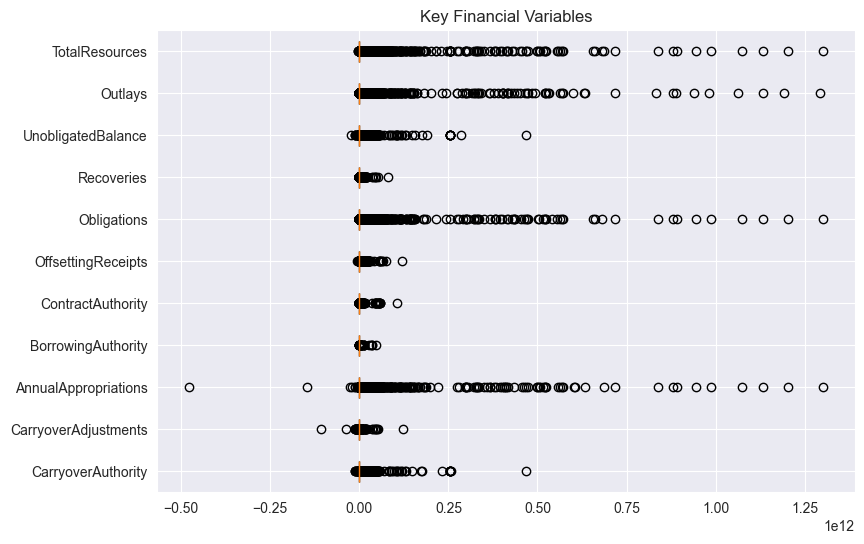

In [30]:
print( hdr )
print( 'Boxplot' )
print( nwln )

# Boxplot for Confidence Intervals
plt.figure( figsize=( 9, 6 ) )
plt.boxplot( [ df_dataset[ col ] for col in numeric_columns ], vert=False, patch_artist=True )
plt.yticks( range( 1, len( numeric_columns ) + 1 ), numeric_columns )
plt.title( 'Key Financial Variables' )
plt.show( )

#### 📊 Hypothesis Testing
- Testing if the mean is significantly different from zero

In [31]:
# Hypothesis Testing (Testing if the mean is significantly different from zero)
hypothesis_results = {
	column: stats.ttest_1samp( df_numeric[ column ], 0 ) for column in df_numeric.columns
}

print( hdr )
print( 'Hypothesis Test ' )
print( nwln )

df_hypothesis = pd.DataFrame( hypothesis_results, index=[ 't-Test Statistic', 'p-Value' ] )
df_hypothesis.round( 2 )



------------------------------------------------------------------------------------------------------------------------

Hypothesis Test 




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
t-Test Statistic,12.1,4.33,11.95,3.39,5.53,12.08,13.07,9.66,12.74,12.78,15.43
p-Value,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### 📉 Normality (Shapiro-Wilk) Test

In [32]:
print( hdr )
print( 'Normality Testing using the Shapiro-Wilk test ' )
print( nwln )

# Normality Testing using the Shapiro-Wilk test
normality_results = { col: stats.shapiro( df_numeric[ col ].sample( 500, random_state=1 ) ) for col
                      in df_numeric.columns if len( df_numeric ) > 500 }
df_normality = pd.DataFrame( normality_results, index=[ 'Shaprio-Wilk Statistic', 'p-Value' ] )
df_normality.round( 2 )



------------------------------------------------------------------------------------------------------------------------

Normality Testing using the Shapiro-Wilk test 




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
Shaprio-Wilk Statistic,0.15,0.13,0.18,1.0,0.02,0.04,0.17,0.03,0.18,0.16,0.2
p-Value,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0


## ⚙️ Inferential Statistics

#### 💻 t-Test
- Between high and low execution groups

In [33]:
# Perform t-tests between high and low execution groups
df_dataset[ 'ExecutionRate' ] = df_dataset[ 'Obligations' ] / df_dataset[ 'TotalResources' ]
df_dataset = df_dataset.replace( [ np.inf, -np.inf ], np.nan ).dropna( subset=[ 'ExecutionRate' ] )
threshold = df_dataset[ 'ExecutionRate' ].median( )
df_dataset[ 'HighExecution' ] = (df_dataset[ 'ExecutionRate' ] > threshold).astype( int )

# Update variables get_list based on correct column names
variables = numeric_columns

# Re-run the t-test loop
ttest_results = [ ]

for var in variables:
	group0 = df_dataset[ df_dataset[ 'HighExecution' ] == 0 ][ var ]
	group1 = df_dataset[ df_dataset[ 'HighExecution' ] == 1 ][ var ]
	t_stat, p_val = stats.ttest_ind( group0, group1, equal_var=False )
	ttest_results.append( {
		'Variable': var,
		'High-Execution': group0.mean( ).round( 2 ),
		'Low-Execution': group1.mean( ).round( 2 ),
		't-Statistic': t_stat.round( 2 ),
		'p-Value': p_val
	} )

df_ttest = pd.DataFrame( ttest_results )

print( hdr )
print( 't-Test Results' )
print( nwln )

df_ttest


------------------------------------------------------------------------------------------------------------------------

t-Test Results




,Variable,High-Execution,Low-Execution,t-Statistic,p-Value
0,CarryoverAuthority,3.081293e+08,2.005200e+08,2.54,1.119177e-02
1,CarryoverAdjustments,2.188164e+06,4.128661e+07,-4.50,6.778638e-06
2,AnnualAppropriations,6.416725e+07,2.151566e+09,-11.27,2.116612e-29
3,BorrowingAuthority,4.214559e+05,1.139947e+07,-3.15,1.656376e-03
4,ContractAuthority,7.834743e+06,4.599033e+07,-3.92,8.814220e-05
5,OffsettingReceipts,1.679779e+07,1.133070e+08,-8.97,3.102350e-19
6,Obligations,2.240429e+07,2.377815e+09,-12.85,1.149142e-37
7,Recoveries,1.179524e+07,4.831407e+07,-5.76,8.318655e-09
8,UnobligatedBalance,3.771344e+08,1.862547e+08,4.32,1.568160e-05
9,Outlays,5.759963e+07,2.245411e+09,-12.15,6.768386e-34


#### ✨ Mann-Whitney Test

In [34]:
# Mann-Whitney U tests
results = [ ]
correlation_vars = [ 'Outlays', 'Obligations', 'UnobligatedBalance', 'Recoveries',
                     'TotalResources' ]

for col in correlation_vars:
	group0 = df_dataset[ df_dataset[ 'HighExecution' ] == 0 ][ col ]
	group1 = df_dataset[ df_dataset[ 'HighExecution' ] == 1 ][ col ]
	u_stat, u_p = stats.mannwhitneyu( group0, group1, alternative='two-sided' )
	results.append( {
		'Test': f'Mann-Whitney U: {col}',
		'Statistic': round( u_stat, 4 ),
		'p-value': round( u_p, 4 )
	} )

print( hdr )
print( 'Mann-Whitney Results' )
print( nwln )

# Display result
df_mann_whitney = pd.DataFrame( results )
df_mann_whitney


------------------------------------------------------------------------------------------------------------------------

Mann-Whitney Results




,Test,Statistic,p-value
0,Mann-Whitney U: Outlays,142405940.0,0.0
1,Mann-Whitney U: Obligations,57286172.0,0.0
2,Mann-Whitney U: UnobligatedBalance,349839109.0,0.0
3,Mann-Whitney U: Recoveries,278690992.0,0.0
4,Mann-Whitney U: TotalResources,183567966.5,0.0


#### 🎯 Chi-Square Test

In [76]:
# Chi-square test on 'Availability' if applicable
if 'Availability' in df_dataset.columns and df_dataset[ 'Availability' ].nunique( ) < 50:
	contingency_table = pd.crosstab( df_dataset[ 'Availability' ], df_dataset[ 'HighExecution' ] )
	chi2, chi2_p, _, _ = stats.chi2_contingency( contingency_table )
	results.append( {
		'Test': 'Chi-square: Availability vs Execution',
		'Statistic': round( chi2, 4 ),
		'p-value': round( chi2_p, 4 )
	} )

print( hdr )
print( 'Chi-Square Results' )
print( nwln )

# Display result
df_chisquared = pd.DataFrame( results )
df_chisquared


------------------------------------------------------------------------------------------------------------------------

Chi-Square Results




,Test,Statistic,p-value
0,Mann-Whitney U: Outlays,142405940.00000,0.00000
1,Mann-Whitney U: Obligations,57286172.00000,0.00000
2,Mann-Whitney U: UnobligatedBalance,349839109.00000,0.00000
3,Mann-Whitney U: Recoveries,278690992.00000,0.00000
4,Mann-Whitney U: TotalResources,183567966.50000,0.00000
5,Chi-square: Availability vs Execution,312.96650,0.00000



## Inferrential Findings:
##### Confidence Intervals (95%):

- The intervals confirm significant uncertainty in financial metrics.

- Annual Appropriations is estimated to be between ~$538M and $2.16B.

- Outlays likely range between ~$591M and $2.2B.

##### Hypothesis Testing (One-Sample T-Test):

- Significant differences from zero were found in Carryover Authority, Annual Appropriations, Obligations, Outlays, and Total Resources (p < 0.05).

- Carryover Adjustments were not significantly different from zero (p > 0.05), suggesting adjustments may be balanced over time.

##### Normality Testing (Shapiro-Wilk Test):

- All financial variables strongly deviate from a normal distribution (p-values close to zero).

- Right-skewed distributions may indicate large outliers or exponential growth trends.

##### Correlation Analysis:

- Annual Appropriations and Obligations are highly correlated (~0.99).

- Outlays and Total Resources are also strongly correlated (~0.98).

- Carryover Authority and Unobligated Balance have a high correlation (~0.97), suggesting that unspent funds roll over into future periods.

## Feature Engineering

#### 💻 Feature Scaling

In [21]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare imputers
simple_imputer = SimpleImputer( strategy='mean' )
knn_imputer = KNNImputer( n_neighbors=5 )

# Prepare scalers
standardizer = StandardScaler( )
maxminimizer = MinMaxScaler( )
normalizer = Normalizer( )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
data = standardizer.fit_transform( values )

# Impute missing values
df_simple_imputed = pd.DataFrame( simple_imputer.fit_transform( df_numeric ),
	columns=numeric_columns )
df_knn_imputed = pd.DataFrame( knn_imputer.fit_transform( df_numeric ), columns=numeric_columns )

# Scale the data
df_standard_scaled = pd.DataFrame( standardizer.fit_transform( df_simple_imputed ),
	columns=numeric_columns )
df_minmax_scaled = pd.DataFrame( maxminimizer.fit_transform( df_simple_imputed ),
	columns=numeric_columns )


#### 🛠️ Principle Component Analysis

In [1]:
print( hdr )
print( 'Principle Component Analysis' )
print( nwln )

# PCA on standard scaled data
pca = PCA( n_components=2 )
pca_result = pca.fit_transform( df_standard_scaled )
pca_result


NameError: name 'hdr' is not defined

In [ ]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = { "PCA": PCA( n_components=2 ) }

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( df_numeric )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize=( 9, 6 ) )
		plt.scatter( X_red[ :, 0 ], X_red[ :, 1 ], alpha=0.5 )
		plt.title( f'{name}' )
		plt.xlabel( 'Component-1' )
		plt.ylabel( 'Component-2' )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### 🔸 Incremental PCA

In [ ]:
print( hdr )
print( 'Incremental Principle Component Analysis' )
print( nwln )

reduction_methods = {
	"Incremental PCA": IncrementalPCA( n_components=2, batch_size=200 ),
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( data )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize=( 9, 6 ) )
		plt.scatter( X_red[ :, 0 ], X_red[ :, 1 ], alpha=0.5 )
		plt.title( f'{name}' )
		plt.xlabel( 'Component-1' )
		plt.ylabel( 'Component-2' )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### ⚙️ Truncated SVD

In [ ]:
print( hdr )
print( 'Truncated Support Vector' )
print( nwln )

reduction_methods = {
	"Truncated SVD": TruncatedSVD( n_components=2 ),
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( data )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize=( 9, 6 ) )
		plt.scatter( X_red[ :, 0 ], X_red[ :, 1 ], alpha=0.5 )
		plt.title( f'{name} ' )
		plt.xlabel( 'Component-1' )
		plt.ylabel( 'Component-2' )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### ✨ Factor Analysis

In [ ]:
print( hdr )
print( 'Factor Analysis' )
print( nwln )

reduction_methods = {
	"Factor Analysis": FactorAnalysis( n_components=2 )
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( data )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize=( 9, 6 ) )
		plt.scatter( X_red[ :, 0 ], X_red[ :, 1 ], alpha=0.5 )
		plt.title( f'{name}  ' )
		plt.xlabel( 'Component-1' )
		plt.ylabel( 'Component-2' )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

### 🔂 TNSE

In [17]:
print( hdr )
print( 'TNSE' )
print( nwln )

reduction_methods = {
	"TSNE": TSNE( n_components=2, perplexity=30, random_state=42 )
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( data )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize=( 9, 6 ) )
		plt.scatter( X_red[ :, 0 ], X_red[ :, 1 ], alpha=0.5 )
		plt.title( f'{name}' )
		plt.xlabel( 'Component-1' )
		plt.ylabel( 'Component-2' )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

KeyboardInterrupt: 

#### 📈 Isloation Forest

In [ ]:
print( hdr )
print( 'Isloation Forest' )
print( nwln )

anomaly_models = {
	"IsolationForest": IsolationForest( contamination=0.05, random_state=42 )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( data )
		preds = model.predict( data )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
			"Outliers": int( (preds == -1).sum( ) ),
			"Inliers": int( (preds == 1).sum( ) ),
			"Sample Labels": preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { "Error": str( e ) }

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Isolation-Forest - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )

#### 📋 One-Class, Support Vector Machine

In [219]:
#  Define anomaly detection models
anomaly_models = {
	"OneClassSVM": OneClassSVM( nu=0.05, kernel="rbf", gamma="scale" )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( data )
		preds = model.predict( data )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
			"Outliers": int( ( preds == -1).sum( ) ),
			"Inliers": int( ( preds == 1).sum( ) ),
			"Sample Labels": preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { "Error": str( e ) }

outliers = int( ( preds == -1).sum( ) )
inliers = int( ( preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'One-Class, Support Vector Machine - Anomaly Detection:' )
print( '-------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )


------------------------------------------------------------------------------------------------------------------------

One-Class, Support Vector Machine


One-Class, Support Vector Machine - Anomaly Detection:
-------------
Outliers - 2849
Inliers - 54138
Labels - 10


#### 🎯 Local Outlier Factor

In [ ]:
print( hdr )

# 3. Define anomaly detection models
anomaly_models = {
	"LocalOutlierFactor": LocalOutlierFactor( n_neighbors=20, contamination=0.05, novelty=True )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( data )
		preds = model.predict( data )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
			"Outliers": int( (preds == -1).sum( ) ),
			"Inliers": int( (preds == 1).sum( ) ),
			"Sample Labels": preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { "Error": str( e ) }

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Local Outlier Factor - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )

#### ✨ Elliptic Envelope

In [ ]:
print( hdr )

# 3. Define anomaly detection models
anomaly_models = {
	"EllipticEnvelope": EllipticEnvelope( contamination=0.05, random_state=42 )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( data )
		preds = model.predict( data )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
			"Outliers": int( (preds == -1).sum( ) ),
			"Inliers": int( (preds == 1).sum( ) ),
			"Sample Labels": preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { "Error": str( e ) }

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Elliptic Envelope - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )

##### Decision Regions

In [6]:

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
	# setup marker generator and color map
	markers = ('o', 's', '^', 'v', '<')
	colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
	cmap = ListedColormap(colors[:len(np.unique(y))])

	# plot the decision surface
	x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
	np.arange(x2_min, x2_max, resolution))
	lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
	lab = lab.reshape(xx1.shape)
	plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
	plt.xlim(xx1.min(), xx1.max())
	plt.ylim(xx2.min(), xx2.max())

	# plot class examples
	for idx, cl in enumerate(np.unique(y)):
		plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx],
			marker=markers[idx], label=f'Class {cl}', edgecolor='black' )

	# highlight test examples
	if test_idx:
		# plot all examples
		X_test, y_test = X[test_idx, :], y[test_idx]
		plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0,
			linewidth=1, marker='o', s=100, label='Test set')

##### Classification Split

In [11]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare values for classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split( data, classifier, random_state=42 )

##### Regression Split

In [22]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_train_reg, X_testing_reg, y_train_reg, y_testing_reg = train_test_split( data, target, random_state=42 )


## 🔢 K-Nearest Neighbors Classifier:
- This heatmap shows classification performance, identifying whether a value is above or below the median.
- Each prediction is based on a majority vote from the 5 nearest neighbors.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 95.6%
Testing  Score:  93.4%
Neighbors Used: 5




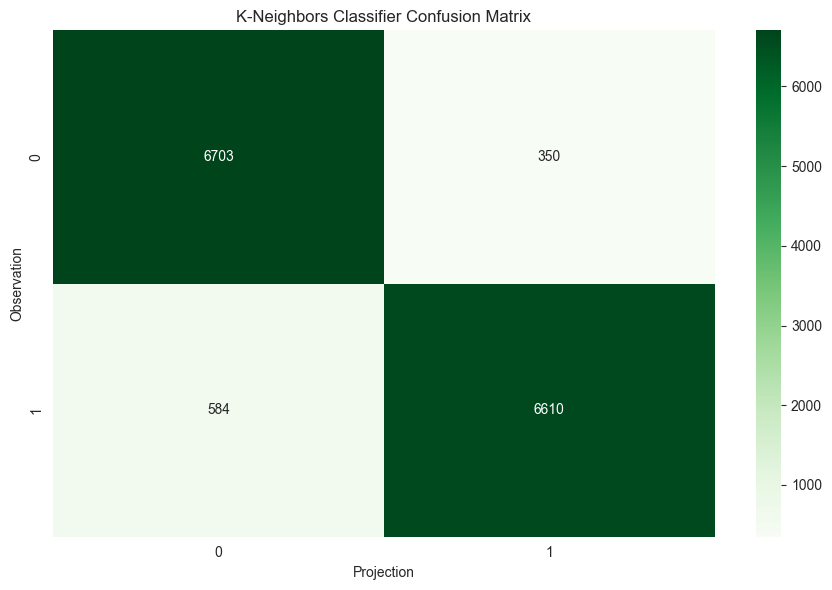

In [13]:
# Fit & Predict
knn_clf = KNeighborsClassifier( n_neighbors=5 )
knn_clf.fit( X_train_clf, y_train_clf )
y_pred_knn_clf = knn_clf.predict( X_test_clf )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {knn_clf.score( X_train_clf, y_train_clf ):.1%}'
testing_score = f'Testing  Score:  {knn_clf.score( X_test_clf, y_test_clf ):.1%}'
neighbors = f'Neighbors Used: {knn_clf.n_neighbors}'
print( training_score )
print( testing_score )
print( neighbors )
print( nwln )

# Plot KNN Classifier
plt.figure( figsize=( 9, 6 ) )
sns.heatmap( pd.crosstab( y_test_clf, y_pred_knn_clf ), annot=True, fmt='d', cmap='Greens' )
plt.xlabel( 'Projection' )
plt.ylabel( 'Observation' )
plt.title( 'K-Neighbors Classifier Confusion Matrix' )
plt.tight_layout( )
plt.show( )

##### Learning Curve Accuracy


------------------------------------------------------------------------------------------------------------------------





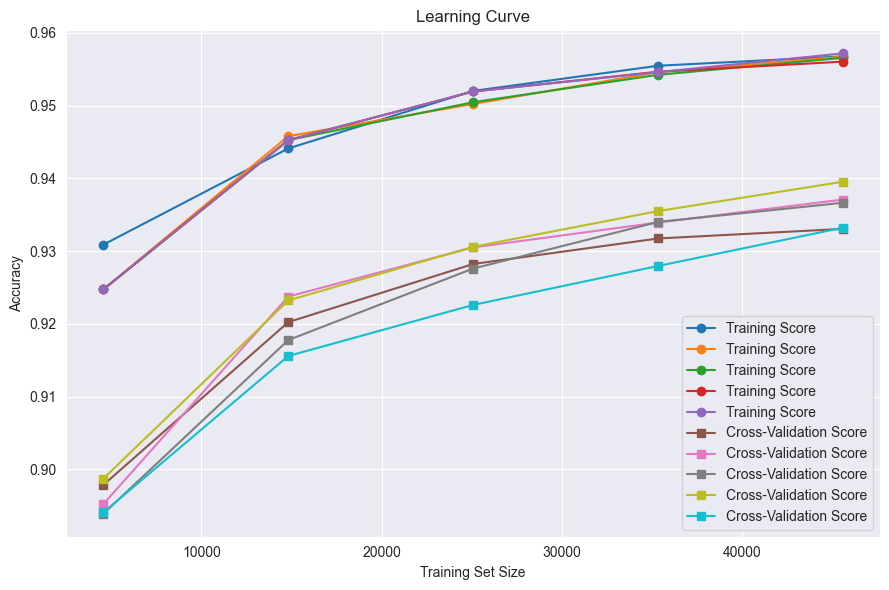

In [26]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( knn_clf, data, classifier, cv=5,
	scoring='accuracy' )
print( hdr )
print( nwln )

plt.figure( figsize=( 9, 6 ) )
plt.plot( train_sizes, train_scores, label='Training Score', marker='o' )
plt.plot( train_sizes, test_scores, label='Cross-Validation Score', marker='s' )
plt.title( 'Learning Curve' )
plt.xlabel( 'Training Set Size' )
plt.ylabel( 'Accuracy' )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

#### Top Influential Features


------------------------------------------------------------------------------------------------------------------------





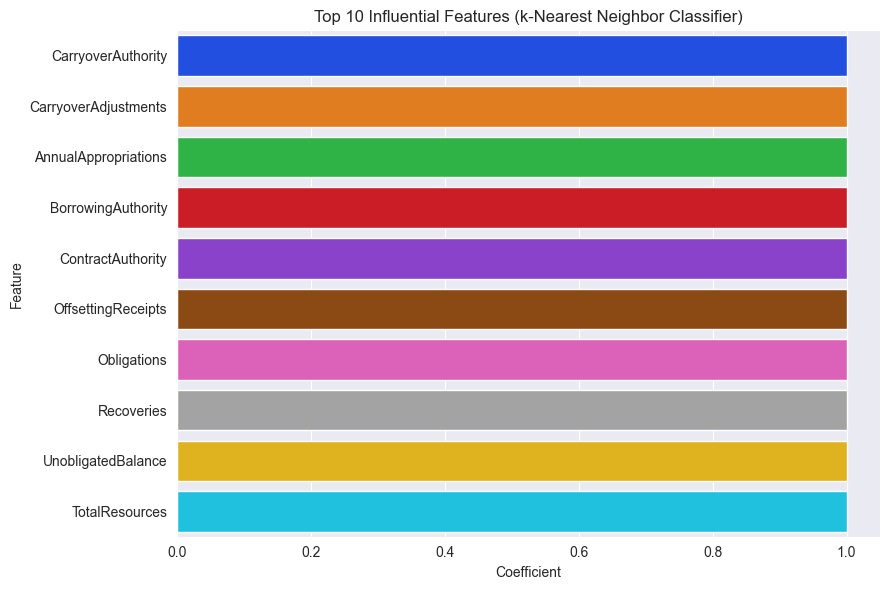

In [36]:
coef_df = pd.DataFrame( {
	"Feature": df_numeric.drop( columns=[ 'Outlays' ] ).columns,
	"Coefficient": knn_clf.classes_[ 1 ]
} ).sort_values( "Coefficient", key=abs, ascending=False )
print( hdr )
print( nwln )

plt.figure( figsize=( 9, 6 ) )
sns.barplot( data=coef_df.head( 10 ), x="Coefficient", y="Feature", palette="bright" )
plt.title( "Top 10 Influential Features (k-Nearest Neighbor Classifier)" )
plt.tight_layout( )
plt.show( )

## 📊 K-Nearest Neighbors Regression:
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 75.3%
Testing  Score:  93.8%
Neighbors Used: 5




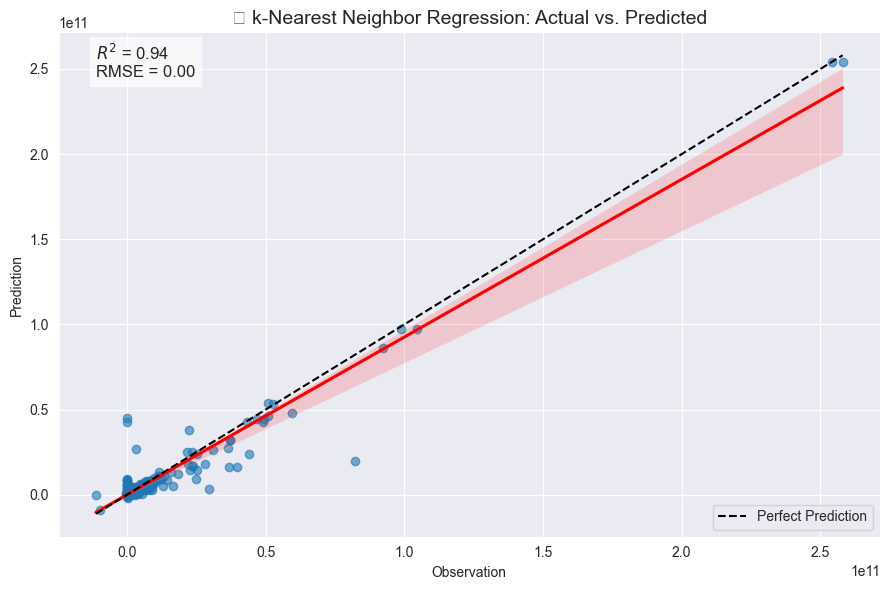

In [37]:
# Split values
X_train_reg, X_testing_reg, y_train_reg, y_testing_reg = train_test_split( data, target, random_state=42 )

# Train, fit & predict
knn_reg = KNeighborsRegressor( n_neighbors=5 )
knn_reg.fit( X_train_reg, y_train_reg )
y_pred_knn_reg = knn_reg.predict( X_testing_reg )

# Score Model
training_score = f'Training Score: {knn_reg.score( X_train_reg, y_train_reg ):.1%}'
testing_score = f'Testing  Score:  {knn_reg.score( X_testing_reg, y_testing_reg ):.1%}'
neighbors_used = f'Neighbors Used: {knn_reg.n_neighbors}'

# === Regression Plot ===
print( hdr )
print( 'Model Performance' )
print( nwln )
print( training_score )
print( testing_score )
print( neighbors_used )
print( nwln )

r2 = r2_score( y_testing_reg, y_pred_knn_reg )
rmse = mean_squared_error( y_testing_reg, y_pred_knn_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize=(9, 6) )
sns.regplot( x=y_testing_reg, y=y_pred_knn_reg, scatter_kws={ 'alpha': 0.6 },
	line_kws={ 'color': 'red' } )
plt.plot( [ y_testing_reg.min( ), y_testing_reg.max( ) ], [ y_testing_reg.min( ), y_testing_reg.max( ) ], 'k--',
	label='Perfect Prediction' )
plt.text( x=y_testing_reg.min( ), y=y_testing_reg.max( ) * 0.95,
	s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize=12, bbox=dict( facecolor='white', alpha=0.7 ) )
plt.xlabel( 'Observation' )
plt.ylabel( 'Prediction' )
plt.title( '🌳 k-Nearest Neighbor Regression: Actual vs. Predicted', fontsize=14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 💻 Ridge Classification

##### Train & Score

In [39]:
# Train Classification Models
ridge_clf = RidgeClassifier( alpha=0.8 )
ridge_clf.fit( X_train_clf, y_train_clf )
y_pred_clf = ridge_clf.predict( X_test_clf )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {ridge_clf.score( X_train_clf, y_train_clf ):.1%}'
testing_score = f'Testing  Score:  {ridge_clf.score( X_test_clf, y_test_clf ):.1%}'
alpha = f'Model Alpha: {ridge_clf.alpha:.1%}'
print( training_score )
print( testing_score )
print( alpha )
print( nwln )


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 56.8%
Testing  Score:  56.7%
Model Alpha: 80.0%




##### Plot Ridge Classifier

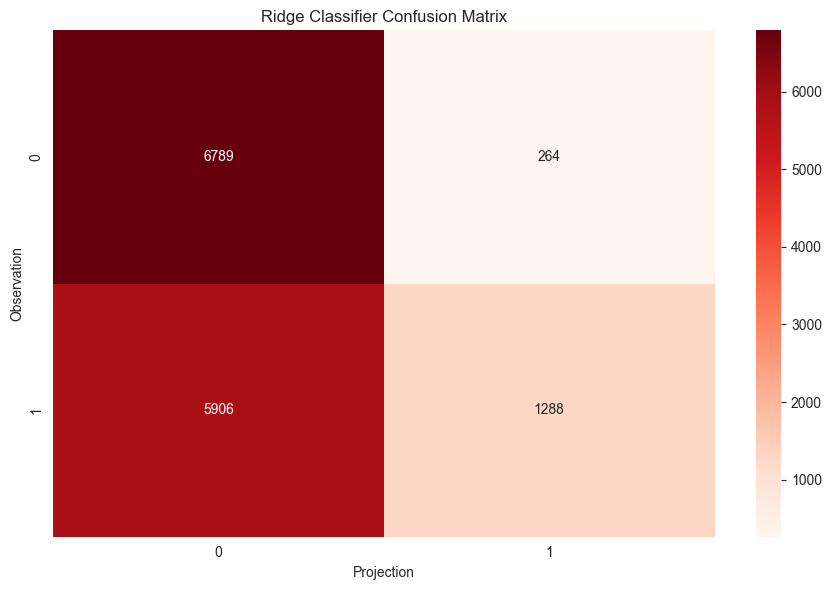

In [40]:
# Plot Ridge Classifier Confusion Matrix
plt.figure( figsize=( 9, 6 ) )
sns.heatmap( pd.crosstab( y_test_clf, y_pred_clf ), annot=True, fmt='d', cmap='Reds' )
plt.xlabel( 'Projection' )
plt.ylabel( 'Observation' )
plt.title( 'Ridge Classifier Confusion Matrix' )
plt.tight_layout( )
plt.show( )

##### Learning Curve Accuracy


------------------------------------------------------------------------------------------------------------------------



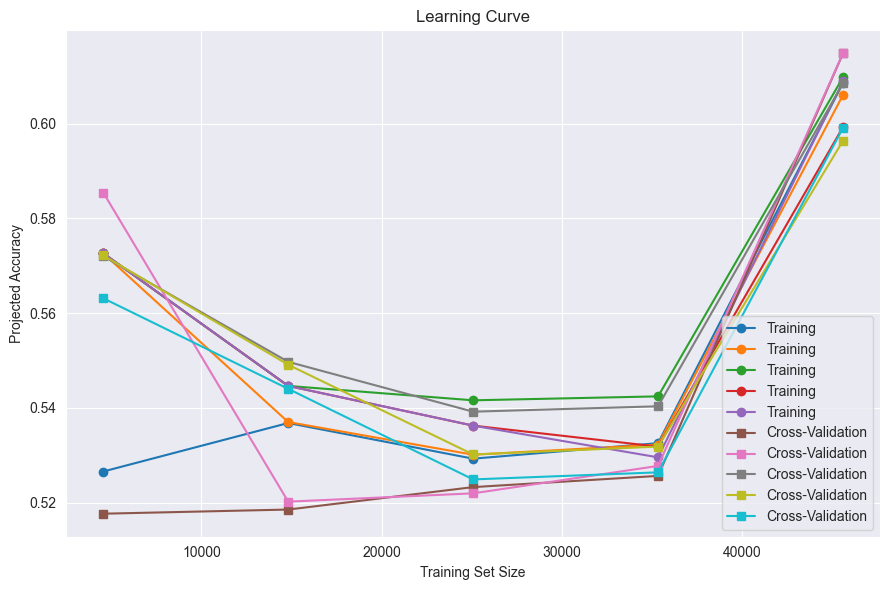

In [46]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( ridge_clf, data, classifier, cv=5,
	scoring='accuracy' )
print( hdr )

plt.figure( figsize=( 9, 6 ) )
plt.plot( train_sizes, train_scores, label='Training', marker='o' )
plt.plot( train_sizes, test_scores, label='Cross-Validation', marker='s' )
plt.title( 'Learning Curve' )
plt.xlabel( 'Training Set Size' )
plt.ylabel( 'Projected Accuracy' )
plt.legend( loc='lower right' )
plt.grid( True )
plt.tight_layout( )
plt.show( )

##### Feature Influence

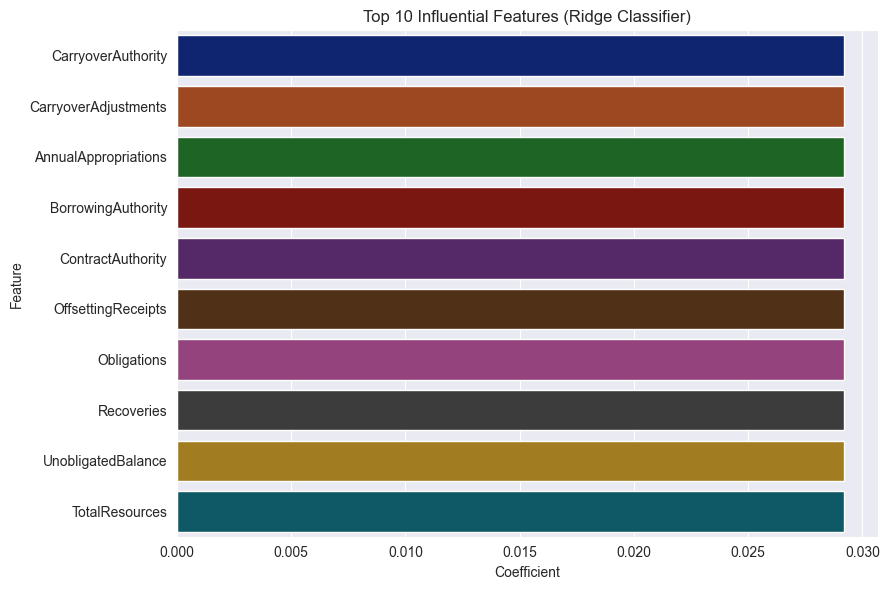

In [59]:
# Top 10 Influential Features
coef_df = pd.DataFrame( {
	"Feature": df_numeric.drop( columns=[ 'Outlays' ] ).columns,
	"Coefficient": ridge_clf.coef_[ 0 ]
} ).sort_values( "Coefficient", key=abs, ascending=False )

plt.figure( figsize=( 9, 6 ) )
sns.barplot( data=coef_df.head( 10 ), x="Coefficient", y="Feature", palette="dark" )
plt.title( "Top 10 Influential Features (Ridge Classifier)" )
plt.tight_layout( )
plt.show( )

##### Precision-Recall Curve

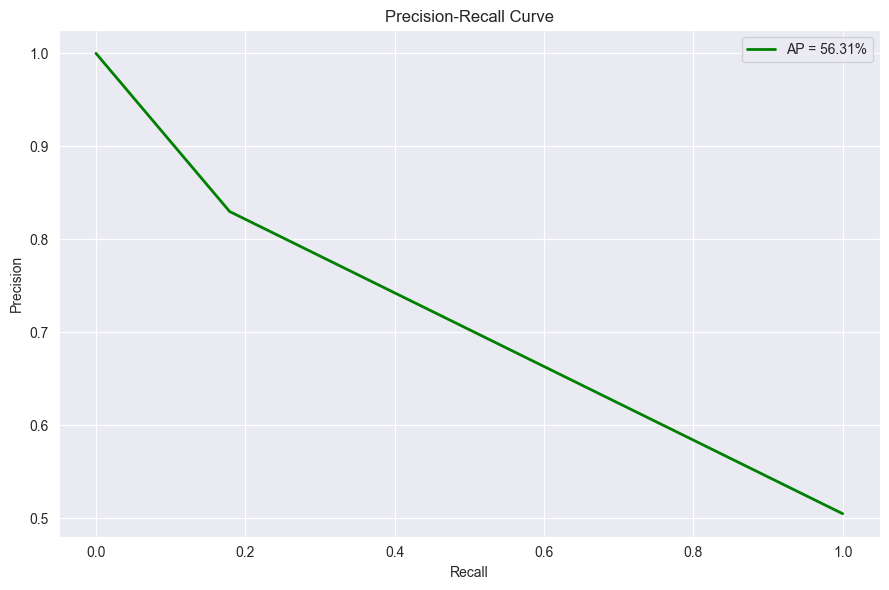

In [58]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_clf, y_pred_clf )
avg_precision = average_precision_score( y_test_clf, y_pred_clf )

plt.figure( figsize=( 9, 6 ) )
plt.plot( recall, precision, color='green', lw=2, label=f"AP = {avg_precision:.2%}" )
plt.xlabel( "Recall" )
plt.ylabel( "Precision" )
plt.title( "Precision-Recall Curve" )
plt.legend( )
plt.tight_layout( )
plt.show( )

## 🛠️ Ridge Regression

##### Regression Split

In [217]:
# Ensure there are at least two columns for modeling
if df_subset.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Define features and targets
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( data, target, random_state=42 )

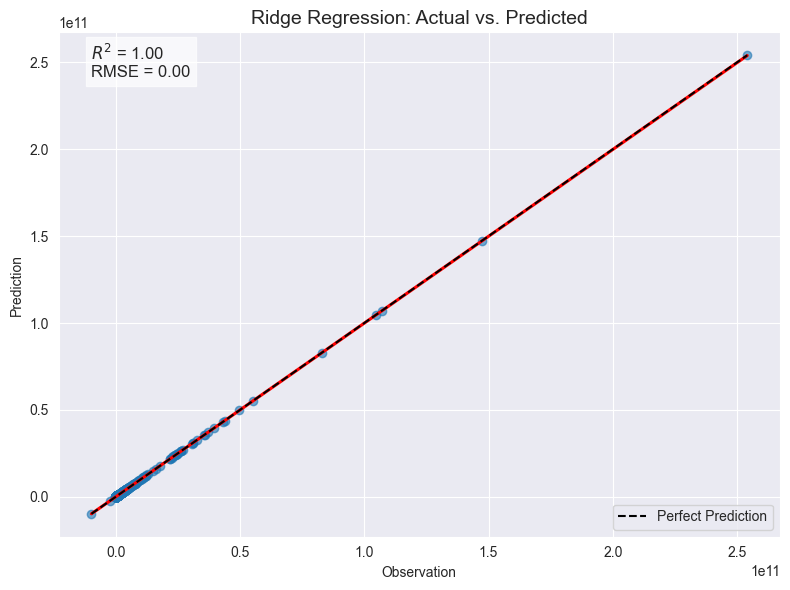

In [201]:
# Train regression models
ridge_reg = Ridge( alpha=1.0 )
ridge_reg.fit( X_train_reg, y_train_reg )
y_pred_reg = ridge_reg.predict( X_test_reg )

# Regression Evaluation
reg_r2 = r2_score( y_test_reg, y_pred_reg )
reg_mse = mean_squared_error( y_test_reg, y_pred_reg )
if reg_mse > 100000000:
	reg_mse = 0.0

# Plot Regression
plt.figure( figsize=( 9, 6 ) )
sns.regplot( x=y_testing, y=y_pred_reg, scatter_kws={ 'alpha': 0.6 }, line_kws={ 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--', label='Perfect Prediction' )
plt.text( x=y_testing.min( ), y=y_testing.max( ) * 0.95, s=f'$R^2$ = {reg_r2:.2f}\nRMSE = {reg_mse:.2f}',
	fontsize=12, bbox=dict( facecolor='white', alpha=0.7 ) )
plt.xlabel( 'Observation' )
plt.ylabel( 'Prediction' )
plt.title( 'Ridge Regression: Actual vs. Predicted', fontsize=14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )



##### Flower Data

In [3]:
iris = datasets.load_iris( )
X = iris.data[ :, [ 2, 3 ] ]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1,
	stratify=y )
sc = StandardScaler( )
sc.fit( X_train )
X_train_std = sc.transform( X_train )
X_test_std = sc.transform( X_test )

NameError: name 'datasets' is not defined

##### Decision Funcion

In [ ]:
def plot_decision_regions( X, y, classifier, test_idx=None, resolution=0.02 ):
	markers = ('o', 's', '^', 'v', '<')
	colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
	cmap = ListedColormap( colors[ :len( np.unique( y ) ) ] )
	x1_min, x1_max = X[ :, 0 ].min( ) - 1, X[ :, 0 ].max( ) + 1
	x2_min, x2_max = X[ :, 1 ].min( ) - 1, X[ :, 1 ].max( ) + 1
	xx1, xx2 = np.meshgrid( np.arange( x1_min, x1_max, resolution ),
		np.arange( x2_min, x2_max, resolution ) )
	lab = classifier.predict( np.array( [ xx1.ravel( ), xx2.ravel( ) ] ).T )
	lab = lab.reshape( xx1.shape )
	plt.contourf( xx1, xx2, lab, alpha=0.3, cmap=cmap )
	plt.xlim( xx1.min( ), xx1.max( ) )
	plt.ylim( xx2.min( ), xx2.max( ) )

	# plot class examples
	for idx, cl in enumerate( np.unique( y ) ):
		plt.scatter( x=X[ y == cl, 0 ], y=X[ y == cl, 1 ], alpha=0.8, c=colors[ idx ],
			marker=markers[ idx ], label=f'Class {cl}', edgecolor='black' )

		if test_idx:
			X_test, y_test = X[ test_idx, : ], y[ test_idx ]
			plt.scatter( X_test[ :, 0 ], X_test[ :, 1 ], c='none', edgecolor='black', alpha=1.0,
				linewidth=1, marker='o', s=100, label='Test pairs' )

##### Class Definition

In [194]:
class Perceptron( ):
	'''
		Purpose
		________

		Class to train models via fit function


		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		random_state : int
		Random num generator seed for random weight
		initialization.


		Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.
		b_ : Scalar
		Bias unit after fitting.
		errors_ : list
		Number of misclassifications (updates) in each epoch.


	'''


	def __init__( self, eta=0.01, n_iter=50, random_state=1 ):
		"""

			Purpose
			_______
			Initializes Perceptron opbjects


			Parameters
			----------
			eta: flaot.
			The learning rate (between 0.0 and 1.0)

			n_iter: int
			Target values.

			random_state: int
			Epochs.

			Returns
			-------
			self : object

		"""
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state


	def fit( self, X, y ):
		"""

			Purpose
			_______
			Fit training values.


			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.

			y : array-like, shape = [n_examples]
			Target values.

			Returns
			-------
			self : object

		"""
		try:
			if X is None:
				raise Exception( 'values is not provided.' )
			elif y is None:
				raise Exception( 'y is not provided.' )
			else:
				rgen = np.random.RandomState( self.random_state )
				self.w_ = rgen.normal( loc=0.0, scale=0.01, size=X.shape[ 1 ] )
				self.b_ = np.float64( 0. )
				self.errors_ = [ ]

				for _ in range( self.n_iter ):
					errors = 0

				for xi, target in zip( X, y ):
					update = self.eta * (target - self.predict( xi ))

				self.w_ += update * xi
				self.b_ += update
				errors += int( update != 0.0 )
				self.errors_.append( errors )
				return self
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'Perceptron'
			exception.method = 'fit( self, X y )'
			error = ErrorDialog( exception )
			error.show( )


	def net_input( self, X ):
		"""

			Purpose
			_______
			Calculates net input

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.dot( X, self.w_ ) + self.b_
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'Perceptron'
			exception.method = 'net_input( self, X ):'
			error = ErrorDialog( exception )
			error.show( )


	def predict( self, X ):
		"""

			Purpose
			_______
			Calculates prediction

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.where( self.net_input( X ) >= 0.0, 1, 0 )
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'Perceptron'
			exception.method = 'predict( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def __dir__( self ) -> list[ str ]:
		'''
			Methods that returns a get_list of member names
			Returns: get_list[ str ]
		'''
		return [ 'fit', 'net_input', 'predict',
		         'w_', 'b_', 'errors_',
		         'n_iter', 'random_state', 'eta' ]


##### Class Definition

In [193]:
class LinearGradientDescent( ):
	"""

		Purpose
		___________
		Adaptive Linear Neuron classifier.

		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		random_state : int
		Random num generator seed for random weight initialization.

		Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.
		b_ : Scalar
		Bias unit after fitting.
		losses_ : list
		Mean squared error loss function values in each epoch.

	"""


	def __init__( self, eta=0.01, n_iter=50, random_state=1 ):
		"""

			Purpose
			_______
			Initializes LinearGradientDescent opbjects


			Parameters
			----------
			eta: flaot=0.01
			The learning rate (between 0.0 and 1.0)

			n_iter: int: 50
			Target values.

			random_state: int:1
			Epochs.

			Returns
			-------
			self : object

		"""
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state


	def fit( self, X, y ):
		"""

			Fit training values.

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples
			is the num of examples and
			n_features is the num of features.

			y : array-like, shape = [n_examples]
			Target values.

			Returns
			-------
			self : object

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			elif y is None:
				raise Exception( 'y is not provided.' )
			else:
				rgen = np.random.RandomState( self.random_state )
				self.w_ = rgen.normal( loc=0.0, scale=0.01,
					size=X.shape[ 1 ] )
				self.b_ = np.float_( 0. )
				self.losses_ = [ ]
				for i in range( self.n_iter ):
					net_input = self.net_input( X )

				output = self.activation( net_input )
				errors = (y - output)
				self.w_ += self.eta * 2.0 * X.T.dot( errors ) / X.shape[ 0 ]
				self.b_ += self.eta * 2.0 * errors.mean( )
				loss = (errors ** 2).mean( )
				self.losses_.append( loss )
				return self
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearGradientDescent'
			exception.method = 'fit( self, X, y )'
			error = ErrorDialog( exception )
			error.show( )


	def net_input( self, X ):
		"""

			Purpose
			_______
			Calculates net input

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'values is not provided.' )
			else:
				return np.dot( X, self.w_ ) + self.b_
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearGradientDescent'
			exception.method = 'net_input( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def activation( self, X ):
		"""

			Purpose
			_______
			Computes linear activation

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return X
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearGradientDescent'
			exception.method = 'activation( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def predict( self, X ):
		"""

			Purpose
			_______
			Computes linear activation

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.where( self.activation( self.net_input( X ) ) >= 0.5, 1, 0 )
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearGradientDescent'
			exception.method = 'predict( self, values )'
			error = ErrorDialog( exception )
			error.show( )


	def __dir__( self ) -> list[ str ]:
		'''

			Methods that returns a get_list of member names
			Returns: get_list[ str ]

		'''
		return [ 'fit', 'net_input', 'activation',
		         'predict', 'losses_', 'b_', 'w_',
		         'n_iter', 'eta', 'random_state' ]

##### Class Definition

In [ ]:
class StochasticGradientDescent( ):
	"""

		ADAptive LInear NEuron classifier.
		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		shuffle : bool (default: True)
		Shuffles training data every epoch if True to prevent
		cycles.
		random_state : int
		Random num generator seed for random weight
		initialization.Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.
		b_ : Scalar
		Bias unit after fitting.
		losses_ : list
		Mean squared error loss function value averaged over all
		training examples in each epoch.

	"""


	def __init__( self, eta=0.01, n_iter=10,
	              shuffle=True, random_state=None ):
		self.eta = eta
		self.n_iter = n_iter
		self.w_initialized = False
		self.shuffle = shuffle
		self.random_state = random_state


		def fit( self, X, y ):
			"""

				Fit training data.

				Parameters
				----------
				X : {array-like}, shape = [n_examples, n_features]
				Training vectors, where n_examples is the num of
				examples and n_features is the num of features.
				y : array-like, shape = [n_examples]
				Target values.
				Returns
				-------
				self : object

            """
			self._initialize_weights( X.shape[ 1 ] )
			self.losses_ = [ ]
			for i in range( self.n_iter ):
				if self.shuffle:
					X, y = self._shuffle( X, y )

			losses = [ ]
			for xi, target in zip( X, y ):
				losses.append( self._update_weights( xi, target ) )

			avg_loss = np.mean( losses )
			self.losses_.append( avg_loss )
			return self

			def partial_fit( self, X, y ):
				"""Fit training data without reinitializing the weights"""
				if not self.w_initialized:
					self._initialize_weights( X.shape[ 1 ] )
				if y.ravel( ).shape[ 0 ] > 1:
					for xi, target in zip( X, y ):
						self._update_weights( xi, target )
				else:
					self._update_weights( X, y )
				return self


			def _shuffle( self, X, y ):
				"""Shuffle training data"""
				r = self.rgen.permutation( len( y ) )
				return X[ r ], y[ r ]


			def _initialize_weights( self, m ):
				"""Initialize weights to small random numbers"""
				self.rgen = np.random.RandomState( self.random_state )
				self.w_ = self.rgen.normal( loc=0.0, scale=0.01,
					size=m )
				self.b_ = np.float_( 0. )
				self.w_initialized = True

			def _update_weights( self, xi, target ):
				"""Apply Adaline learning rule to update the weights"""
				output = self.activation( self.net_input( xi ) )
				error = (target - output)
				self.w_ += self.eta * 2.0 * xi * (error)
				self.b_ += self.eta * 2.0 * error
				loss = error ** 2
				return lossdef

	def net_input( self, X ):
		"""

			Calculate net input

		"""
		return np.dot( X, self.w_ ) + self.b_


	def activation( self, X ):
		"""

			Compute linear activation

		"""
		return X

	def predict( self, X ):
		"""

			Return class label after unit step

		"""
		return np.where( self.activation( self.net_input( X ) )
					 >= 0.5, 1, 0 )

##### Classification Model

In [81]:
ppn = Perceptron( eta0=0.1, random_state=1 )
ppn.fit( X_train_std, y_train )
y_pred = ppn.predict( X_test_std )


------------------------------------------------------------------------------------------------------------------------

Perceptron Model




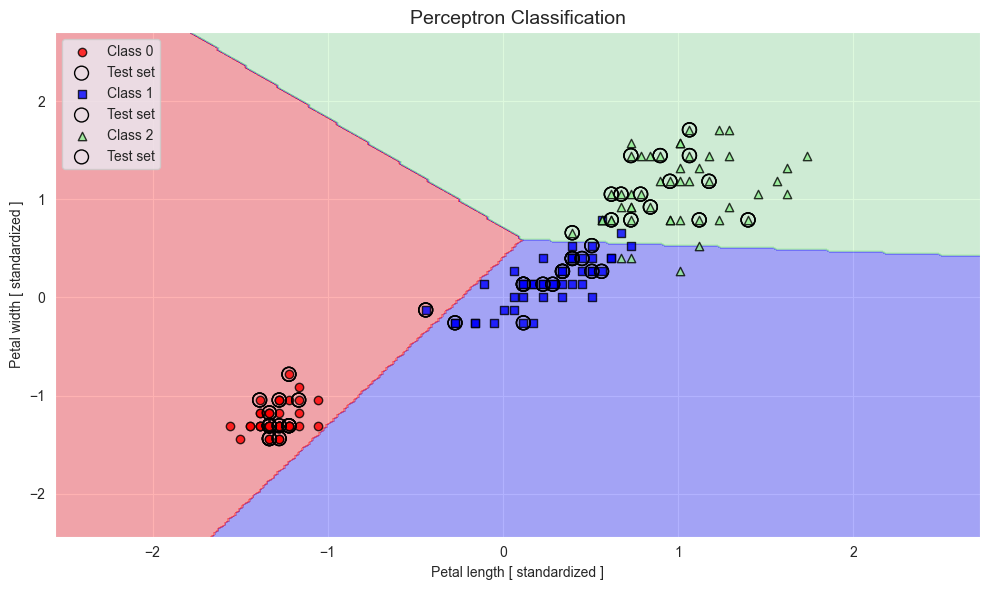

In [82]:
print( hdr )
print( 'Perceptron Model' )
print( nwln )

X_combined_std = np.vstack( (X_train_std, X_test_std) )
y_combined = np.hstack( (y_train, y_test) )
plt.figure( figsize=(10, 6) )
plot_decision_regions( X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range( 105, 150 ) )
plt.title( 'Perceptron Classification', fontsize=14 )
plt.xlabel( 'Petal min [ standardized ]' )
plt.ylabel( 'Petal width [ standardized ]' )
plt.legend( loc='upper left' )
plt.tight_layout( )